# Solar-System15-Mixed-Precision

<ul id="top">
<li><a href="#Load-packages"> 
             Load Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li> 

<li><a href="#Initial-value-problem:-Solar-System15">
              Initial value problem: Solar-System15</a></li>

<li><a href="#Ode-problem">
             Ode problem</a></li>
 
<li><a href="#Error-in-energy">
             Error in energy</a></li> 

<li><a href="#Work-Precision-diagrams">
             Work-Precision diagrams</a></li> 

</ul>  

## Load packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates
using RecursiveArrayTools
using JLD2, FileIO

In [3]:
setprecision(BigFloat, 108);

In [3]:
#plotly()

<a href="#top">Back to the top</a>

## Computer properties

In [5]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

1

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [6]:
using Hwloc
Hwloc.num_physical_cores()

2

<a href="#top">Back to the top</a>

## Initial value problem: Solar-System15

In [7]:
include("../examples/Nbody.jl")
include("../examples/InitialNBody15.jl")
u0128, Gm128 =InitialNBody15(BigFloat)

q0128=u0128[2,:,:]
v0128=u0128[1,:,:]

dt=1
t0=0.0
t1=20*dt    #1000.
mysaveat=1  #10

tspan128=(BigFloat(t0),BigFloat(t1))
prob128=ODEProblem(NbodyODE!,u0128,tspan128,Gm128);

In [8]:
lpp=Float64.(Gm128);

In [9]:
tspan128

(0.0, 20.0)

<a href="#top">Back to the top</a>

## Ode problem

### Test solution

In [10]:
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128,;lpp=lpp);
sol =solve(prob128,Vern9(),saveat=mysaveat,abstol=1e-24,reltol=1e-24,maxiters=100000);
@save "./Data/solarsystem15small_test_solF128.jld2" sol
#@load "./Data/solarsystem15small_test_solF128.jld2" sol
test_sol = TestSolution(sol);

### IRKGL16 (Fixed-Step)

In [11]:
sol1 =solve(prob128,IRKGL16(),dt=dt,saveat=mysaveat,adaptive=false,mixed_precision=false);
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  2027
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          20
Number of rejected steps:                          0

In [12]:
sol2 = solve(prob128,IRKGL16(),dt=dt,saveat=mysaveat,adaptive=false,
                             mixed_precision=true, low_prec_type=Float64);
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  1666
Number of function 2 evaluations:                  1016
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          20
Number of rejected steps:                          0

<a href="#top">Back to the top</a>

## Error in energy

In [14]:
setprecision(BigFloat, 256)
u0128, Gm128 =InitialNBody15(BigFloat)
E0=NbodyEnergy(u0128,Gm128)

ΔE = map(x->NbodyEnergy(BigFloat.(x),Gm128), sol.u)./E0.-1
ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm128), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm128), sol2.u)./E0.-1

(Float32(maximum(abs.(ΔE))),Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE2))))

(4.646337f-28, 1.8013276f-20, 1.8013276f-20)

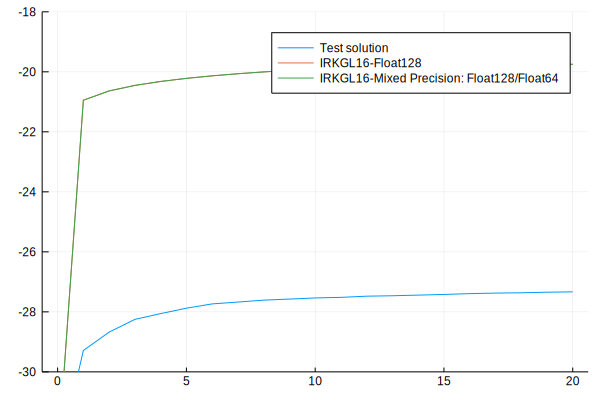

In [16]:
ylimit1=-30
ylimit2=-18
plot(sol.t,log10.(abs.(ΔE)), label="Test solution",
    ylims=(ylimit1,ylimit2),)
plot!(sol1.t,log10.(abs.(ΔE1)), label="IRKGL16-Float128",
     ylims=(ylimit1,ylimit2),)
plot!(sol2.t,log10.(abs.(ΔE2)), label="IRKGL16-Mixed Precision: Float128/Float64",
     ylims=(ylimit1,ylimit2),)

<a href="#top">Back to the top</a>

## Work-Precision diagrams

In [25]:
Threads.nthreads()

1

In [26]:
abstols = 1.0 ./ 10.0 .^ (8:18)
reltols = 1.0 ./ 10.0 .^ (8:18)
dts=16*0.866.^(0:length(reltols)-1);

In [27]:
setups = [ Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,mixed_precision=false) 
           Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts,mixed_precision=true,low_prec_type=Float64)
]
wp1 = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1,maxiters=1000000)
plot(wp1)

MethodError: MethodError: no method matching Dict(::Pair{Symbol,IRKGL16}, ::Pair{Symbol,Bool}, ::Pair{Symbol,Array{Float64,1}}; mixed_precision=false)
Closest candidates are:
  Dict(!Matched::Pair{K,V}...) where {K, V} at dict.jl:123 got unsupported keyword argument "mixed_precision"
  Dict(::Pair...) at dict.jl:124 got unsupported keyword argument "mixed_precision"
  Dict(::Any) at dict.jl:127 got unsupported keyword argument "mixed_precision"

<a href="#top">Back to the top</a>